In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import intake
from xmip.preprocessing import rename_cmip6
from xmip.postprocessing import combine_datasets, _concat_sorted_time

In [2]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json") #get data catalogue

In [3]:
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,700
grid_label,10
zstore,514818
dcpp_init_year,61


In [4]:
col.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,<NA>,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,<NA>,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,<NA>,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,<NA>,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,<NA>,20170706
...,...,...,...,...,...,...,...,...,...,...,...
514813,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,tas,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,<NA>,20211207
514814,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,tauu,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,<NA>,20211207
514815,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,hur,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,<NA>,20211207
514816,CMIP,EC-Earth-Consortium,EC-Earth3-Veg,historical,r1i1p1f1,Amon,hus,gr,gs://cmip6/CMIP6/CMIP/EC-Earth-Consortium/EC-E...,<NA>,20211207


Do a specific search:

In [5]:
expts = ['historical', 'ssp585']

query = dict(source_id=['ACCESS-CM2','CanESM5','NorESM2-LM'],
    experiment_id=expts,
    table_id='Amon',
    variable_id=['tas'],
    member_id = 'r1i1p1f1',
)

col_subset = col.search(require_all_on=["source_id"], **query)
col_subset.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,CSIRO-ARCCSS,ACCESS-CM2,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/...,<NA>,20191108
1,ScenarioMIP,CSIRO-ARCCSS,ACCESS-CM2,ssp585,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/ScenarioMIP/CSIRO-ARCCSS/ACCE...,<NA>,20210317
2,ScenarioMIP,CCCma,CanESM5,ssp585,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp...,<NA>,20190429
3,CMIP,CCCma,CanESM5,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...,<NA>,20190429
4,CMIP,NCC,NorESM2-LM,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCC/NorESM2-LM/historica...,<NA>,20190815
5,ScenarioMIP,NCC,NorESM2-LM,ssp585,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/ScenarioMIP/NCC/NorESM2-LM/ss...,<NA>,20191108


Open (not load!) datasets, workflow typically uses a dictionary of dictionaries with keys and xarray datasets as items:

In [6]:
ddict_ = col_subset.to_dataset_dict(**{'zarr_kwargs':{'consolidated':True,'use_cftime':True},'aggregate':True}) 
ddict_


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


<div><progress max="6" value="6"></progress> 100.00% [6/6 00:23&lt;00:00]</div>

{'CMIP.NCC.NorESM2-LM.historical.Amon.gn': <xarray.Dataset> Size: 110MB
 Dimensions:         (member_id: 1, dcpp_init_year: 1, time: 1980, lat: 96,
                      lon: 144, bnds: 2)
 Coordinates:
   * member_id       (member_id) object 8B 'r1i1p1f1'
   * dcpp_init_year  (dcpp_init_year) object 8B None
   * time            (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:...
   * lat             (lat) float64 768B -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
   * lon             (lon) float64 1kB 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
     height          float64 8B ...
     lat_bnds        (lat, bnds) float64 2kB dask.array<chunksize=(96, 2), meta=np.ndarray>
     lon_bnds        (lon, bnds) float64 2kB dask.array<chunksize=(144, 2), meta=np.ndarray>
     time_bnds       (time, bnds) object 32kB dask.array<chunksize=(1980, 2), meta=np.ndarray>
 Dimensions without coordinates: bnds
 Data variables:
     tas             (member_id, dcpp_init_year, time, lat, lon) float32 109MB 

Example with preprocessing routine from xmip:

In [7]:
col_subset.to_dataset_dict(**{'zarr_kwargs':{'consolidated':True,'use_cftime':True},'aggregate':True,'preprocess':rename_cmip6}) 


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


<div><progress max="6" value="6"></progress> 100.00% [6/6 00:00&lt;00:00]</div>

{'ScenarioMIP.CCCma.CanESM5.ssp585.Amon.gn': <xarray.Dataset> Size: 113MB
 Dimensions:         (y: 64, x: 128, time: 3432, member_id: 1,
                      dcpp_init_year: 1, bnds: 2)
 Coordinates:
   * y               (y) float64 512B -87.86 -85.1 -82.31 ... 82.31 85.1 87.86
   * x               (x) float64 1kB 0.0 2.812 5.625 8.438 ... 351.6 354.4 357.2
   * time            (time) object 27kB 2015-01-16 12:00:00 ... 2300-12-16 12:...
   * member_id       (member_id) object 8B 'r1i1p1f1'
   * dcpp_init_year  (dcpp_init_year) object 8B None
     height          float64 8B ...
 Dimensions without coordinates: bnds
 Data variables:
     tas             (member_id, dcpp_init_year, time, y, x) float32 112MB dask.array<chunksize=(1, 1, 3432, 64, 128), meta=np.ndarray>
     lon_bounds      (x, bnds) float64 2kB dask.array<chunksize=(128, 2), meta=np.ndarray>
     lat_bounds      (y, bnds) float64 1kB dask.array<chunksize=(64, 2), meta=np.ndarray>
     time_bounds     (time, bnds) object 5

In [8]:
ddict = combine_datasets(ddict_,_concat_sorted_time,match_attrs =['source_id', 'grid_label','table_id','variant_label','variable_id'],
                         combine_func_kwargs={'join':'inner','coords':'minimal','compat':'override'})   
ddict

{'NorESM2-LM.gn.Amon.r1i1p1f1.tas': <xarray.Dataset> Size: 167MB
 Dimensions:         (member_id: 1, dcpp_init_year: 1, time: 3012, lat: 96,
                      lon: 144, bnds: 2)
 Coordinates:
   * member_id       (member_id) object 8B 'r1i1p1f1'
   * dcpp_init_year  (dcpp_init_year) object 8B None
   * time            (time) object 24kB 1850-01-16 12:00:00 ... 2100-12-16 12:...
   * lat             (lat) float64 768B -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
   * lon             (lon) float64 1kB 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
     height          float64 8B ...
     lat_bnds        (lat, bnds) float64 2kB dask.array<chunksize=(96, 2), meta=np.ndarray>
     lon_bnds        (lon, bnds) float64 2kB dask.array<chunksize=(144, 2), meta=np.ndarray>
     time_bnds       (time, bnds) object 48kB dask.array<chunksize=(1980, 2), meta=np.ndarray>
 Dimensions without coordinates: bnds
 Data variables:
     tas             (member_id, dcpp_init_year, time, lat, lon) float32 167MB dask.ar

In [9]:
def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")
    
def global_mean(ds,time_dim):
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {time_dim}
    return (ds * weight).mean(other_dims)

ddict_gm = {}
for k,v in ddict.items():
    ddict_gm[k] = global_mean(v.groupby(v.time.dt.year).mean(),time_dim='year')
ddict_gm

{'NorESM2-LM.gn.Amon.r1i1p1f1.tas': <xarray.Dataset> Size: 4kB
 Dimensions:  (year: 251)
 Coordinates:
   * year     (year) int64 2kB 1850 1851 1852 1853 1854 ... 2097 2098 2099 2100
     height   float64 8B ...
 Data variables:
     tas      (year) float64 2kB dask.array<chunksize=(1,), meta=np.ndarray>
 Attributes: (12/68)
     Conventions:                      CF-1.7 CMIP-6.2
     activity_id:                      CMIP
     branch_method:                    Hybrid-restart from year 1600-01-01 of ...
     branch_time:                      0.0
     branch_time_in_child:             0.0
     branch_time_in_parent:            430335.0
     ...                               ...
     intake_esm_dataset_key:           CMIP.NCC.NorESM2-LM.historical.Amon.gn
     axis:                             Y
     bounds:                           lat_bnds
     long_name:                        Latitude
     standard_name:                    latitude
     units:                            degrees_north

In [10]:
ds = xr.concat(ddict_gm.values(),dim='source_id',join='outer')
ds['source_id'] = [k.source_id for k in ddict_gm.values()]
ds.load()

<xarray.Dataset> Size: 15kB
Dimensions:    (source_id: 3, year: 451)
Coordinates:
  * source_id  (source_id) <U10 120B 'NorESM2-LM' 'ACCESS-CM2' 'CanESM5'
  * year       (year) int64 4kB 1850 1851 1852 1853 1854 ... 2297 2298 2299 2300
    height     float64 8B 2.0
Data variables:
    tas        (source_id, year) float64 11kB 287.6 287.8 287.7 ... 304.4 304.4
Attributes: (12/68)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    Hybrid-restart from year 1600-01-01 of ...
    branch_time:                      0.0
    branch_time_in_child:             0.0
    branch_time_in_parent:            430335.0
    ...                               ...
    intake_esm_dataset_key:           CMIP.NCC.NorESM2-LM.historical.Amon.gn
    axis:                             Y
    bounds:                           lat_bnds
    long_name:                        Latitude
    standard_name:                    latitude
    units:                            degrees_north

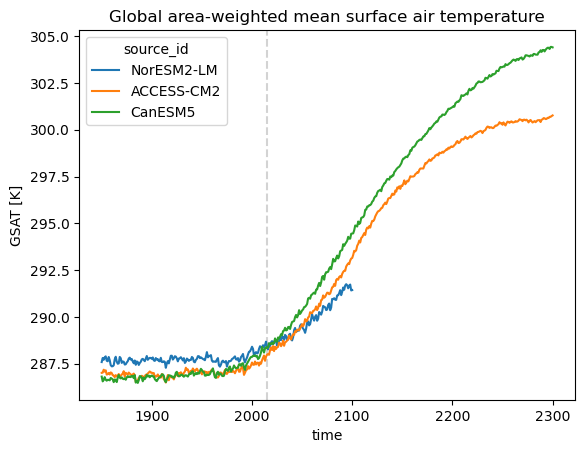

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
ds.tas.plot.line(hue='source_id')
#ds.tas.mean(dim='source_id').plot(ax=ax,color='black')
ax.set_title('Global area-weighted mean surface air temperature')
ax.set_ylabel('GSAT [K]')
ax.axvline(x=2015,color='lightgrey',linestyle='dashed',zorder=0)

In [12]:
import xesmf as xe

def regrid_to_common(ds):
    regridder = xe.Regridder(ds,
                             xr.Dataset({"lat": (["lat"], np.arange(-90, 90, 1), {"units": "degrees_north"}),
                                         "lon": (["lon"], np.arange(0, 360, 1), {"units": "degrees_east"}),}),
                             'bilinear',ignore_degenerate=True,periodic=True)
    return regridder(ds)



ModuleNotFoundError: No module named 'ESMF'

In [ ]:
ddict_regridded = {}
for k,v in ddict.items():
    ddict_regridded[k] = regrid_to_common(v.groupby(v.time.dt.year).mean())

In [ ]:
ds_gridded = xr.concat(ddict_regridded.values(),dim='source_id',join='outer')
ds_gridded['source_id'] = [k.source_id for k in ddict_gm.values()]

In [ ]:
ds_gridded.load()

In [ ]:
def compute_future_change(ds):
    return ds.sel(year=np.arange(2071,2100)).mean(dim='year') - ds.sel(year=np.arange(1995,2014)).mean(dim='year')

plt.figure()
compute_future_change(ds_gridded.tas).plot(col='source_id',vmin=-5,vmax=5,cmap='coolwarm',cbar_kwargs={'label':'dGSAT [K]'})
plt.figure()
compute_future_change(ds_gridded.tas).mean(dim='source_id').plot(vmin=-5,vmax=5,cmap='coolwarm',cbar_kwargs={'label':'dGSAT [K]'})
plt.title('Ensemble mean')